# Загрузка библиотек

In [1]:
# загружаем необходимые библиотеки
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from statistics import median
from statistics import mean
from statistics import mode

## Загрузка данных

In [2]:
# загружаем X_train, X_test. В y_train загружаем данные своей разметки.
X_train = np.load ( 'X_train.npy')
X_test = np.load ( 'X_test.npy')
y_train = pd.read_csv('y_train_250_5_61_-2.csv')
y = y_train.copy()

In [3]:
print(X_train.shape)
print(X_test.shape)

(323, 40, 100)
(54, 40, 100)


In [4]:
# посмотрим на целевую переменную
print(y.shape)
y.sample(5)

(32300, 1)


,class_new
7590,0
14421,0
5774,0
22689,1
7996,0


## Оценка данных

0 - команда "жест open";  
1 - команда "сгиб мизинца";  
2 - команда "сгиб безымянного пальца";  
3 - команда "сгиб среднего пальца";  
4 - команда "жест пистолет";  
5 - команда "сгиб указательного пальца";  
6 - команда "сгиб большога пальца";  
7 - команда "жест ОК";  
8 - команда "жест grab";  

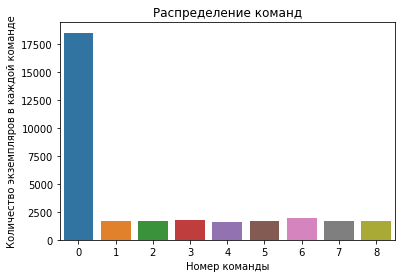

In [5]:
# построим график распределения команд 
y_counts = y['class_new'].value_counts()
plot = sns.barplot(data = y_train, x = y_counts.index, y = y_counts)
plot.set_title('Распределение команд')
plot.set_xlabel('Номер команды')
plot.set_ylabel('Количество экземпляров в каждой команде');

In [6]:
# УДАЛИТЬ
def sensor_treshold_filtr(array, tres = 250):
    """Функция производит пороговую фильтрацию массива. 
    Исключаются строки, где максимальное значение не превышает пороговое значение.
    Аргументы: array - входной массив,
               tres - пороговое значение.
    Возвращает отфильтрованный массив."""
    low_sensors_set = set()               # 
    for i in range(array.shape[0]):
        for j in range(array.shape[1]):
            if array[i,j].max() <= tres:
                low_sensors_set.add(j)
    low_sens_list = list(low_sensors_set)
    array_out = np.delete(array, low_sens_list, 1)
    return array_out

In [7]:
# применим функцию sensor_treshold_filtr к нашему массиву признаков,
# которая производит пороговую фильтрацию.
X_tres_train = sensor_treshold_filtr(X_train)
X_tres_train.shape

(323, 16, 100)

## Алгоритм решения задачи.
`y_train` содержит номер команды для каждого временного значения.
`X_train` содержит 40 значений показаний датчиков для каждого временного значения.
Из этого, предположим, что по 40 значениям показаний датчиков можно определить номер
команды для каждого временного значения. Для решения этой задачи нам потребуется
классификатор. Получается, что X_train вытягивается по шкале времени в 32300 строк 
данных для обучения моделей. В процессе оценки графиков, выяснилось, что некоторые 
датчики не несут в себе информацию и были просто удалены из X_train c помощью
пороговой фильтрации.

Важное состояние руки - это состояние `open`, встречается оно очень часто.
Поэтому предложено сделать отдельный бинарный классификатор на определение именно
этого состояния. Так же данный подход помогает избежать дисбаланса классов.
В итоге определяем был ли сделан какой-либо жест.

Следующим этапом решения будет тренировка многоклассового классификатора на оставшиеся
номера команд, при этом из этих данных исключаются строки в которых бинарный 
классификатор предсказывает состояние `open`. В итоге определяем конкретный номер
жеста, который был сделан.

Для сабмита и для реального использования мы будем использовать предсказания обеих 
моделей по алгоритму:
1. Разворачиваем тестовые данные относительно оси времени и подаем вектор значений
датчиков на модель бинарной классификации.
2. Если распознается жест `open`, тогда в качестве целевого значения для этого временного значения формируем 0.
3. Иначе вектор значений из показаний датчиков отправляется в модель многоклассовой классификации, после которой в целевой переменной формируется номер команды, предсказанный этой моделью. 
4. Для исключения дребезга в целевой переменной присутствует постобработка предсказанных значений с использованием моды.


Формируем данные для построения бинарной классификации: вытягивает относительно
оси времени массив признаков, чтобы он соответствовал длине вектора целевой переменной

In [8]:
flatten_X = pd.DataFrame(np.transpose(X_tres_train,(0,2,1)).reshape(32300, -1).astype(int))

In [9]:
flatten_X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32300 entries, 0 to 32299
Data columns (total 16 columns):
 #   Column  Non-Null Count  Dtype
---  ------  --------------  -----
 0   0       32300 non-null  int32
 1   1       32300 non-null  int32
 2   2       32300 non-null  int32
 3   3       32300 non-null  int32
 4   4       32300 non-null  int32
 5   5       32300 non-null  int32
 6   6       32300 non-null  int32
 7   7       32300 non-null  int32
 8   8       32300 non-null  int32
 9   9       32300 non-null  int32
 10  10      32300 non-null  int32
 11  11      32300 non-null  int32
 12  12      32300 non-null  int32
 13  13      32300 non-null  int32
 14  14      32300 non-null  int32
 15  15      32300 non-null  int32
dtypes: int32(16)
memory usage: 2.0 MB


Задаем вектор целевой переменной и сравниваем размерности наших данных.

In [10]:
flatten_y = np.array(y["class_new"])
flatten_y.shape[0] == flatten_X.shape[0]

True

Оцениваем количество данных, когда выполнялся жест или 
рука находилась в спокойном состоянии.

In [11]:
print(flatten_y[flatten_y > 0].shape[0])
print(flatten_y[flatten_y == 0].shape[0])

13795
18505


Добавляем признак `not_open` для бинарной классификации.

In [12]:
df_y = pd.DataFrame(flatten_y, columns=["class"])
df_y["not_open"] = df_y["class"].apply(lambda x: 1 if x > 0 else 0)
df_y.sample(10)

,class,not_open
796,0,0
14829,0,0
13502,2,1
27417,0,0
21235,0,0
13712,1,1
32177,0,0
27691,3,1
4631,0,0
11570,0,0


## Cross Validation

Сделаем кросс-валидацию для оценки устойчивости работы наших моделей.
Подробное описание каждого шага будет ниже, когда будем обучать модели 
для предсказания тестовых значений.

In [13]:
# количество фолдов для кроссвалидации
n_folds = 5

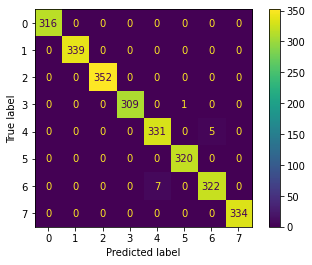

              precision    recall  f1-score   support

           1       1.00      1.00      1.00       316
           2       1.00      1.00      1.00       339
           3       1.00      1.00      1.00       352
           4       1.00      1.00      1.00       310
           5       0.98      0.99      0.98       336
           6       1.00      1.00      1.00       320
           7       0.98      0.98      0.98       329
           8       1.00      1.00      1.00       334

    accuracy                           1.00      2636
   macro avg       1.00      1.00      1.00      2636
weighted avg       1.00      1.00      1.00      2636

0.9950682852807283


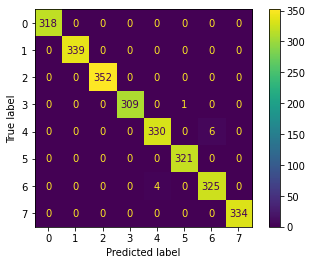

              precision    recall  f1-score   support

           1       1.00      1.00      1.00       318
           2       1.00      1.00      1.00       339
           3       1.00      1.00      1.00       352
           4       1.00      1.00      1.00       310
           5       0.99      0.98      0.99       336
           6       1.00      1.00      1.00       321
           7       0.98      0.99      0.98       329
           8       1.00      1.00      1.00       334

    accuracy                           1.00      2639
   macro avg       1.00      1.00      1.00      2639
weighted avg       1.00      1.00      1.00      2639

0.9954500198665862


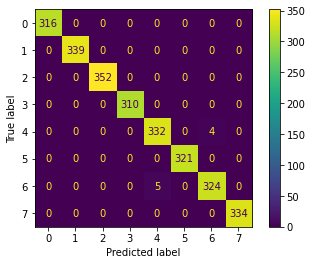

              precision    recall  f1-score   support

           1       1.00      1.00      1.00       316
           2       1.00      1.00      1.00       339
           3       1.00      1.00      1.00       352
           4       1.00      1.00      1.00       310
           5       0.99      0.99      0.99       336
           6       1.00      1.00      1.00       321
           7       0.99      0.98      0.99       329
           8       1.00      1.00      1.00       334

    accuracy                           1.00      2637
   macro avg       1.00      1.00      1.00      2637
weighted avg       1.00      1.00      1.00      2637

0.9958290234832986


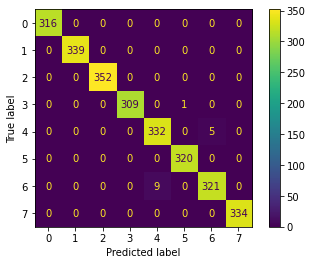

              precision    recall  f1-score   support

           1       1.00      1.00      1.00       316
           2       1.00      1.00      1.00       339
           3       1.00      1.00      1.00       352
           4       1.00      1.00      1.00       310
           5       0.97      0.99      0.98       337
           6       1.00      1.00      1.00       320
           7       0.98      0.97      0.98       330
           8       1.00      1.00      1.00       334

    accuracy                           0.99      2638
   macro avg       0.99      0.99      0.99      2638
weighted avg       0.99      0.99      0.99      2638

0.9954502361492443


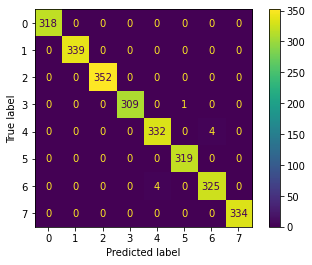

              precision    recall  f1-score   support

           1       1.00      1.00      1.00       318
           2       1.00      1.00      1.00       339
           3       1.00      1.00      1.00       352
           4       1.00      1.00      1.00       310
           5       0.99      0.99      0.99       336
           6       1.00      1.00      1.00       319
           7       0.99      0.99      0.99       329
           8       1.00      1.00      1.00       334

    accuracy                           1.00      2637
   macro avg       1.00      1.00      1.00      2637
weighted avg       1.00      1.00      1.00      2637

0.9956775950627401


In [14]:
skf = StratifiedKFold(n_splits=n_folds,random_state=42,shuffle=True)

df_y_1 = df_y["not_open"]
skf.get_n_splits(flatten_X, df_y_1)

# создадим список всех метрик с кросс-валидации и посчитаем их среднее
scores = []

for fold_id, (train_index, test_index) in enumerate(skf.split(flatten_X, df_y_1)):

    X_train_bin, X_test_bin = flatten_X.iloc[train_index], flatten_X.iloc[test_index]
    y_train_bin, y_test_bin = df_y_1.iloc[train_index], df_y_1.iloc[test_index]
    
    logreg_0 = LogisticRegression(random_state=42, max_iter = 5000, solver = 'lbfgs', penalty='none')
    logreg_0.fit(X_train_bin, y_train_bin)
    
    prediction_bin = logreg_0.predict(X_test_bin)
    

   # мультиклассовая классификация
    not_open_indexes = df_y["class"][df_y["class"] > 0].index
    actions_x = flatten_X.loc[not_open_indexes]
    actions_y = df_y["class"].loc[not_open_indexes]
    actions_y.value_counts()
    
    open_action_predict = logreg_0 .predict(actions_x)

    act_df = pd.DataFrame(open_action_predict, columns=["not_open"], index=not_open_indexes)
    pure_action_index = act_df["not_open"][act_df["not_open"] > 0 ].index
    clear_action_X = actions_x.loc[pure_action_index]
    clear_action_y = actions_y.loc[pure_action_index]
    clear_action_y.value_counts()
    
    train_act_X, test_act_X, train_act_y, test_act_y = train_test_split(
    clear_action_X,
    clear_action_y,
    random_state=42,
    test_size=0.2,
    stratify=clear_action_y
    )

    act_logreg = LogisticRegression(random_state=42, max_iter=15000, solver = 'lbfgs')
    act_logreg.fit(train_act_X,train_act_y)

    act_prediction = act_logreg.predict(test_act_X)
    
    act_cm = confusion_matrix(test_act_y, act_prediction)
    disp = ConfusionMatrixDisplay(confusion_matrix=act_cm)
    disp.plot()

    plt.show()

    print(classification_report(test_act_y, act_prediction))
    
    scores.append(accuracy_score(test_act_y, act_prediction))
    print(np.mean(scores))


Видим, что на всех наборах данных значения метрик достаточно высокие и стабильные, переобучение не наблюдается. Делаем вывод, что подобраны оптимальные модели машинного обучения. 

Обучим модель на всех тренировочных данных

## Бинарная классификация

In [15]:
# выделим 20% данных на тестовую выборку (параметр test_size)
X_train_bin, X_test_bin, y_train_bin, y_test_bin = train_test_split(
    flatten_X, df_y["not_open"],
    test_size=0.2,
    random_state=19,
    stratify=df_y["not_open"]
)

In [16]:
#Обучаем модель
logreg_0 = LogisticRegression(random_state=42, max_iter = 5000, solver = 'lbfgs', penalty='none')
logreg_0.fit(X_train_bin, y_train_bin)

LogisticRegression(max_iter=5000, penalty='none', random_state=42)

In [17]:
prediction_bin = logreg_0.predict(X_test_bin)

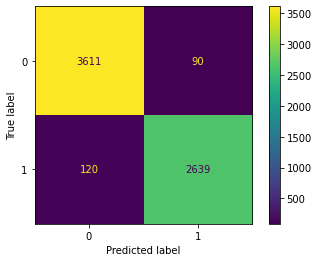

              precision    recall  f1-score   support

           0       0.97      0.98      0.97      3701
           1       0.97      0.96      0.96      2759

    accuracy                           0.97      6460
   macro avg       0.97      0.97      0.97      6460
weighted avg       0.97      0.97      0.97      6460



In [18]:
# для наглядности полученных результатов выведем confusion matrix
bin_labels = {0: "Open", 1: "not open"}
cm = confusion_matrix(y_test_bin, prediction_bin)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=bin_labels)
disp.plot()

plt.show()

print(classification_report(y_test_bin, prediction_bin))

Получили достаточно высокие метрики для бинарной классификации

## Мультиклассовая классификация

In [19]:
X_train_bin

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15
30520,1763,1591,2136,1364,756,849,1855,3007,1474,2308,2070,1389,1884,1164,1544,423
25154,1428,1533,2035,1264,648,804,1809,2608,1370,2162,1973,1403,1543,1162,1606,403
27829,1105,1360,1581,1036,640,728,1787,2467,1419,2854,1361,1062,1505,1145,1705,625
13553,716,1234,1145,616,920,906,2037,3156,1273,2035,1914,1255,1196,1047,1612,416
492,994,839,878,996,385,617,1621,1968,1368,2506,1275,940,2150,1229,1607,768
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
23644,749,646,1095,611,479,616,1732,2308,1346,2379,1160,888,929,1113,1967,332
30708,1296,1522,2033,1088,793,866,2022,2580,1381,1882,1763,1096,976,1081,1875,413
28444,1009,1058,1457,951,528,629,1900,2489,1708,3400,1723,1452,1338,1185,1727,587
31382,1269,1263,1900,1129,646,825,1887,2472,1169,1857,1561,1044,935,1087,1929,365


In [20]:
X_tres_train[0].T

array([[1123., 1450., 1743., ..., 1169., 1677.,  718.],
       [1125., 1441., 1738., ..., 1170., 1673.,  730.],
       [1121., 1444., 1732., ..., 1169., 1670.,  727.],
       ...,
       [1026., 1360., 1560., ..., 1156., 1655.,  738.],
       [1027., 1358., 1556., ..., 1172., 1653.,  744.],
       [1025., 1358., 1554., ..., 1173., 1655.,  743.]])

In [21]:
# создаем массив на основе y_train c преобразованием размерности.
str_y = np.array(y_train["class_new"]).reshape(323,100)
str_y[123]

array([7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7,
       7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7,
       7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], dtype=int64)

Open duration: 74


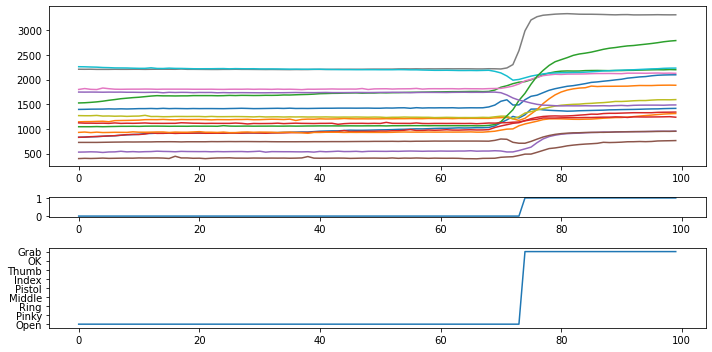

In [22]:
# на графике виден переход с 0 до 1 при выполнении жеста.
index = 48
xdata = np.arange(100)
data = logreg_0.predict(X_tres_train[index].T)
fig, axs = plt.subplots(3, 1, figsize=(10, 5), gridspec_kw={'height_ratios': [4,0.5,2]})
axs[0].plot(xdata,X_tres_train[index].T)
axs[1].plot(xdata, data)
axs[2].plot(xdata, str_y[index])
axs[2].set_yticks(
    np.arange(9),
    ['Open', 'Pinky', 'Ring', 'Middle', 'Pistol', 'Index', 'Thumb', 'OK', 'Grab'])
fig.tight_layout()

print(f"Open duration: {len(data[data==0])}")

In [23]:
# формируем данные для многоклассовой классификации, где берем 
# только те данные, где был совершен жест.
not_open_indexes = df_y["class"][df_y["class"] > 0].index
actions_x = flatten_X.loc[not_open_indexes]
actions_y = df_y["class"].loc[not_open_indexes]
actions_y.value_counts()

6    1974
3    1768
2    1711
5    1704
1    1688
7    1670
8    1668
4    1612
Name: class, dtype: int64

In [24]:
actions_x.sample(5)

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15
7490,820,1131,1260,856,490,752,1704,2129,1334,2457,1441,1003,1777,1239,1850,819
27557,878,692,776,833,350,582,1687,2380,1496,2986,1305,1076,2296,1185,1627,871
20087,1417,1699,2037,1428,817,909,1985,2529,1314,1624,2021,1203,1823,1238,1933,835
7744,963,711,754,900,403,683,1668,2136,1309,2445,1456,1054,2073,1134,1727,611
6940,1236,1073,968,1232,466,763,1657,2209,1497,2881,1493,1213,2340,1277,1659,843


Теперь из имеющихся данных исключаем строки, в которых бинарная классификация
определяет состояние руки `open`.

In [25]:
open_action_predict = logreg_0.predict(actions_x)
act_df = pd.DataFrame(open_action_predict, columns=["not_open"], index=not_open_indexes)
pure_action_index = act_df["not_open"][act_df["not_open"] > 0 ].index

# формируем данные, которые содержат 'чистые' движения.
clear_action_X = actions_x.loc[pure_action_index]
clear_action_y = actions_y.loc[pure_action_index]
clear_action_y.value_counts()


3    1760
2    1696
5    1681
8    1668
7    1645
6    1603
1    1581
4    1551
Name: class, dtype: int64

In [26]:
# Обучаем вторую модель многоклассовой классификации, 
# которой на вход подаем данные после результата работы первой модели.
train_act_X, test_act_X, train_act_y, test_act_y = train_test_split(
    clear_action_X,
    clear_action_y,
    random_state=42,
    test_size=0.2,
    stratify=clear_action_y
)

act_logreg = LogisticRegression(random_state=42, max_iter=15000, solver = 'lbfgs')
act_logreg.fit(train_act_X,train_act_y)


LogisticRegression(max_iter=15000, random_state=42)

Оценим модель многоклассовой классификации.

In [27]:
act_prediction = act_logreg.predict(test_act_X)

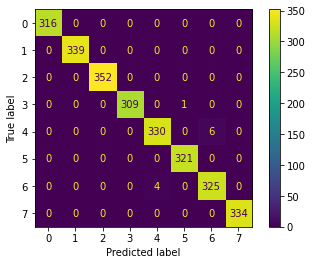

              precision    recall  f1-score   support

           1       1.00      1.00      1.00       316
           2       1.00      1.00      1.00       339
           3       1.00      1.00      1.00       352
           4       1.00      1.00      1.00       310
           5       0.99      0.98      0.99       336
           6       1.00      1.00      1.00       321
           7       0.98      0.99      0.98       329
           8       1.00      1.00      1.00       334

    accuracy                           1.00      2637
   macro avg       1.00      1.00      1.00      2637
weighted avg       1.00      1.00      1.00      2637



In [28]:
# Посмотрим на метрики
act_cm = confusion_matrix(test_act_y, act_prediction)
disp = ConfusionMatrixDisplay(confusion_matrix=act_cm)
disp.plot()

plt.show()

print(classification_report(test_act_y, act_prediction))

Видими достаточно хорошие показания метрик.

Оценим визуально работу классификатора. Сразу добавим для сглаживания моду.

Open duration: 72


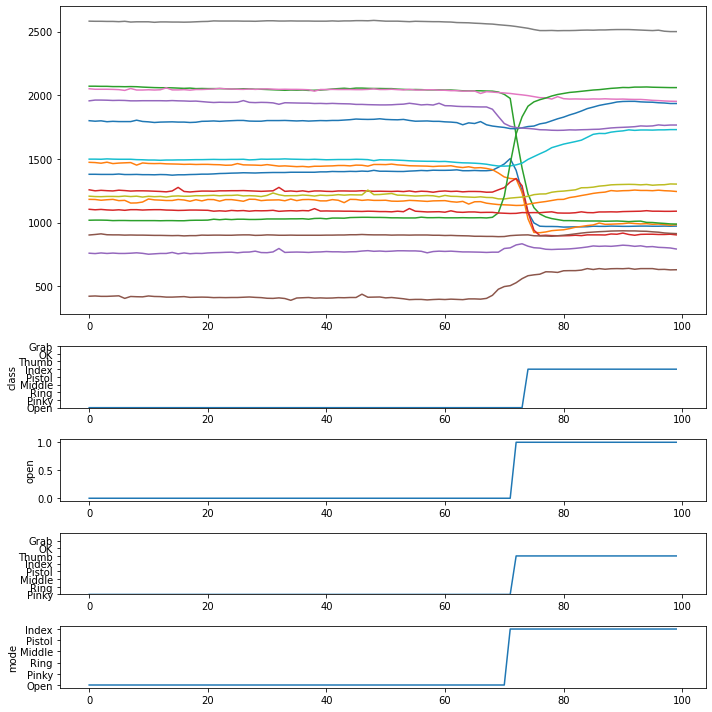

In [29]:
sample_index = 256
xdata = np.arange(100)
sensor_values = X_tres_train[sample_index].T
data = np.zeros((100,))
act_data = np.zeros((100,))
for index, values in enumerate(sensor_values):
    if logreg_0.predict([values]):
        data[index] = 1
        act_data[index] = act_logreg.predict([values])

subm_mode = []
for k in range(len(act_data)):
    subm_mode.append(mode(act_data[k:(k+4)]))

# настройка графиков
fig, axs = plt.subplots(5, 1, figsize=(10, 10), gridspec_kw={'height_ratios': [6,1.2,1.2,1.2,1.2]})
axs[0].plot(xdata,X_tres_train[sample_index].T)
axs[1].plot(xdata, str_y[sample_index])
axs[1].set_ylim([0,8])
axs[1].set_ylabel(ylabel="class", labelpad=1)
axs[2].plot(xdata, data)
axs[2].set_ylabel(ylabel="open", labelpad=1)
axs[3].plot(xdata, act_data)
axs[3].set_ylim([0,8])
axs[1].set_yticks(
    np.arange(9),
    ['Open', 'Pinky', 'Ring', 'Middle', 'Pistol', 'Index', 'Thumb', 'OK', 'Grab'])
axs[3].set_yticks(
    np.arange(8),
    ['Pinky', 'Ring', 'Middle', 'Pistol', 'Index', 'Thumb', 'OK', 'Grab'])
axs[4].set_yticks(
    np.arange(9),
    ['Open', 'Pinky', 'Ring', 'Middle', 'Pistol', 'Index', 'Thumb', 'OK', 'Grab'])
fig.tight_layout()
fig.tight_layout()
fig.tight_layout()
axs[4].plot(xdata, subm_mode)
axs[4].set_ylabel(ylabel="mode", labelpad=1)
fig.tight_layout()
print(f"Open duration: {len(data[data==0])}")

# Submission

In [31]:
# загружаем пример sample_submission
subm_y = pd.read_csv("sample_submission.csv")
subm_len = subm_y.shape[0]
subm_len

5400

Преобразуем тестовые данные под вид данных, которые принимают наши модели.

In [32]:
test_tres_X = sensor_treshold_filtr(X_test)
test_resp_X = pd.DataFrame(
    np.transpose(test_tres_X,(0,2,1)).reshape(subm_len, -1).astype(int)
)
test_resp_X.shape

(5400, 16)

Для сабмита и для реального использования мы будем использовать предсказания обеих 
моделей по алгоритму:
1. Разворачиваем тестовые данные относительно оси времени и подаем вектор значений
датчиков на модель бинарной классификации.
2. Если распознается жест `open`, тогда в качестве целевого значения для этого временного значения формируем 0.
3. Иначе вектор значений из показаний датчиков отправляется в модель многоклассовой классификации, после которой в целевой переменной формируется номер команды, предсказанный этой моделью. 
4. Для исключения дребезга в целевой переменной присутствует постобработка предсказанных значений с использованием моды.

In [33]:
# формируем наш submission
subm = []
for values in test_resp_X.values:
    if logreg_0.predict([values]):
        subm.append(act_logreg.predict([values])[0])
    else:
        subm.append(0)
len(subm)

5400

In [34]:
act_logreg.predict([values])[0]

4

В момент выполнения пользователем команды на сигналах датчиков наблюдаются 
переходные процессы, которые дают неоднозначное определение классов. 
Для сглаживания этой неоднозначности предназначен блок постпроцессинговой обработки.

В нем мы используем сглаживание модой с окном 7.

Данное значение было определено экспериментальным путём.

In [35]:
from statistics import mode

def smooth_row(row, mode_value=7):
    """Сглаживание дребезга.

    Сглаживание дребезга в строках с использованием моды.

    Аргументы:
        row: строка с дребезгом.
        mode_value: количество значений, по которым происходит сглаживание,
            по умолчанию 7.
    
    Возвращает:
        smoothing_row: сглаженная строка.

    """
    smoothing_row = []
    for k in range(len(row)):
        smoothing_row.append(mode(row[k:(k + mode_value)]))
    len(smoothing_row)
    return smoothing_row              

In [36]:
smooth_subm7 = smooth_row(subm, 7)
len(smooth_subm7)


5400

In [37]:
# записываем файл 
subm_y["class"] = smooth_subm7
subm_y.to_csv("submission_mode_2_logreg_mode7.csv", index=False)

Score: 0.97407

In [38]:
subm_y

,sample-timestep,class
0,323-0,4
1,323-1,4
2,323-2,4
3,323-3,4
4,323-4,4
...,...,...
5395,376-95,4
5396,376-96,4
5397,376-97,4
5398,376-98,4
